In [1]:
import pandas as pd
import sys
sys.path.append('..')  # Adjust the path based on your project structure
import json
import re
import ast
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, RocCurveDisplay
import matplotlib.pyplot as plt
import os.path as osp
import os
from glob import glob
from sklearn.metrics import average_precision_score
import datetime

In [2]:
# experiment_folder = '/home/ubuntu/efs/videoMAE/scripts/MPIIGroupInteraction'
# run_name = 'videomae_vit_base_patch16_224_kinetic_400_base'

experiment_folder = r'D:\Project-mpg microgesture\human_micro_gesture_classifier\scripts\miga_smg'
run_name = 'videomae_vit_base_patch16_224_kinetic_400_densepose_dual_resample'

# run_name = 'videomae_vit_base_patch16_224_kinetic_400_densepose_dual'

In [3]:
from pathlib import Path
def load_and_parse_txt(path_or_list, feature_names, is_multi_label=False):
    # Read the text file into a list of lines
    if isinstance(path_or_list, list):
        
        df_list = []
        logit_columns_list = []
        pred_columns_list = []
        gt_columns_list = []
        for p in path_or_list:
            df, logit_columns, pred_columns, gt_columns = load_and_parse_txt(p, feature_names)
            df_list.append(df)
            logit_columns_list.append(logit_columns)
            pred_columns_list.append(pred_columns)
            gt_columns_list.append(gt_columns)
        return pd.concat(df_list), logit_columns_list, pred_columns_list, gt_columns_list
    
    elif isinstance(path_or_list, str):
        path = path_or_list

    with open(path, 'r') as file:
        lines = file.readlines()
    


    # Extract relevant information from each line
    data = []
    indecies = []
    for line in lines[1:]:

        
        # Use regex to find index, predictions, and targets
        if is_multi_label:
            match = re.match(r'(\d+\-[^ ]+)\s+\[([^\]]+)\]\s+\[([^\]]+)\]\s+(\d+)\s+(\d+)', line.strip())
            if match:
        
    
                # index = int(match.group(1))
                index = match.group(1)
                
                # Extract model predictions and convert to list using ast
                logits_str = match.group(2)
                logits = list(ast.literal_eval(logits_str))
                
                predictions = ((np.array(logits)>0.5).astype(int)).tolist()
    
    
                # Extract targets and convert to list using ast
                targets_str = f'[{match.group(3)}]'
                targets = list(np.array(ast.literal_eval(targets_str)))
    
                
                row_data = logits + predictions + targets 
                row_data = np.array(row_data)
                data.append(row_data)
                # indecies.append(int(index))
                indecies.append(index)
                # Create column names
            logit_columns = [f"logit-{name}" for name in feature_names]
            pred_columns = [f"pred-{name}" for name in feature_names]    
            gt_columns = [f"gt-{name}" for name in feature_names]       
            columns = logit_columns + pred_columns + gt_columns 
        else:
            match = re.match(r'(.*?)\s+\[([^\]]+)\]\s+(\d+)\s+(\d+)\s+(\d+)', line.strip())
            if match:
        
    
                # index = int(match.group(1))
                index = match.group(1)
                
                # Extract model predictions and convert to list using ast
                logits_str = match.group(2)
                logits = list(ast.literal_eval(logits_str))
                
                predictions = [np.argmax(logits)]
    
    
                # Extract targets and convert to list using ast
                targets = [match.group(3)]
    
                
                row_data = logits + predictions + targets 
                row_data = np.array(row_data)
                data.append(row_data)
                # indecies.append(int(index))
                indecies.append(index)
            


            # Create column names
            logit_columns = [f"logit-{name}" for name in feature_names]
            pred_columns = ['pred']    
            gt_columns = ['gt']       
            columns = logit_columns + pred_columns + gt_columns 

    # Create Pandas DataFrame
    df = pd.DataFrame(data, columns=columns, index=indecies)


    df[pred_columns+gt_columns] = df[pred_columns+gt_columns].astype(int)
    # print(df.iloc[0])
    # print(df.tail(1))
    # df['filenames'] = file_names
    df['log_name'] = osp.basename(path)

    return df, logit_columns, pred_columns, gt_columns
    # return data, columns


In [4]:
# path_to_weights = '/home/ubuntu/efs/videoMAE/scripts/dyadic_communication_001/dataset/weights.json'
# experiment_folder = '/home/ubuntu/efs/videoMAE/scripts/dyadic_communication_5vid_clean'
# run_name = 'videomae_vit_base_patch16_224_tubemasking_ratio_0.9_kinetic_400'
path_to_weights = osp.join(experiment_folder,run_name,'dataset/weights.json')
with open(path_to_weights, 'r') as json_file:
    positive_weights_dict = json.load(json_file)

        
feature_names = [entry['class'] for entry in positive_weights_dict['data']]

In [5]:
def pars_metadata(metadata):
    metadata_dict_list = []
    for line in metadata:
        metadata_dict_list.append(ast.literal_eval(line))
    df = pd.DataFrame(metadata_dict_list)
    return df, metadata_dict_list

In [6]:
path_to_log = glob(osp.join(experiment_folder,run_name,'outputs_eval','*.txt'))
# path_to_dataset = osp.join(experiment_folder,run_name,'dataset','test.csv')
path_to_dataset = osp.join(experiment_folder,run_name,'dataset','val.csv')
# Get names of file names from the csv file

df_csv = pd.read_csv(path_to_dataset)
file_names = df_csv['filenames'].tolist()
metadata = df_csv['metadata'].tolist()
df_metadata, metadata_dict_list = pars_metadata(metadata)

In [7]:
df_csv

,Unnamed: 0,filenames,folder_name,durations,view,labels,metadata
0,0,Sample0031_color_0001.mp4,validation,89,center,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","{'sample_id': '0031_0001', 'start_frame': 940,..."
1,1,Sample0031_color_0002.mp4,validation,84,center,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","{'sample_id': '0031_0002', 'start_frame': 1245..."
2,2,Sample0031_color_0003.mp4,validation,105,center,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","{'sample_id': '0031_0003', 'start_frame': 1482..."
3,3,Sample0031_color_0004.mp4,validation,82,center,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","{'sample_id': '0031_0004', 'start_frame': 1744..."
4,4,Sample0031_color_0005.mp4,validation,68,center,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","{'sample_id': '0031_0005', 'start_frame': 1865..."
...,...,...,...,...,...,...,...
632,99,Sample0035_color_0100.mp4,validation,59,center,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","{'sample_id': '0035_0100', 'start_frame': 2361..."
633,100,Sample0035_color_0101.mp4,validation,71,center,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","{'sample_id': '0035_0101', 'start_frame': 2399..."
634,101,Sample0035_color_0102.mp4,validation,93,center,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","{'sample_id': '0035_0102', 'start_frame': 2436..."
635,102,Sample0035_color_0103.mp4,validation,61,center,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","{'sample_id': '0035_0103', 'start_frame': 2447..."


In [8]:
df_metadata.head()

,sample_id,start_frame,end_frame,label_txt,view,filenames,durations
0,0031_0001,940,1029,Moving legs,center,Sample0031_color_0001.mp4,89
1,0031_0002,1245,1329,Moving legs,center,Sample0031_color_0002.mp4,84
2,0031_0003,1482,1587,Moving legs,center,Sample0031_color_0003.mp4,105
3,0031_0004,1744,1826,Moving legs,center,Sample0031_color_0004.mp4,82
4,0031_0005,1865,1933,Moving legs,center,Sample0031_color_0005.mp4,68


In [9]:


df, logit_columns, pred_columns, gt_columns = load_and_parse_txt(path_to_log, feature_names)
# data, columns = load_and_parse_txt(path_to_log, feature_names)
# df = df.drop(columns='log_name').groupby('filenames').mean()
logit_columns=logit_columns[0]
pred_columns=pred_columns[0]
gt_columns=gt_columns[0]

In [10]:
# df[['pred','gt']]
df

,logit-0,logit-1,logit-2,logit-3,logit-4,logit-5,logit-6,logit-7,logit-8,logit-9,logit-10,logit-11,logit-12,logit-13,logit-14,logit-15,logit-16,pred,gt,log_name
D:\Project-mpg microgesture\smg\smg_split_files\validation\Sample0031_color_0001,-0.061798095703125,-0.03509521484375,0.023681640625,-0.08636474609375,0.07354736328125,-0.04058837890625,-0.017578125,0.051971435546875,0.06964111328125,-0.07489013671875,-0.058319091796875,0.039215087890625,-0.0257720947265625,-0.0141448974609375,-0.1160888671875,-0.07684326171875,-0.048065185546875,4,2,0.txt
D:\Project-mpg microgesture\smg\smg_split_files\validation\Sample0031_color_0002,-0.0614013671875,-0.035003662109375,0.0235137939453125,-0.0859375,0.07318115234375,-0.04034423828125,-0.0174560546875,0.051727294921875,0.06927490234375,-0.07464599609375,-0.05804443359375,0.038909912109375,-0.0256500244140625,-0.01403045654296875,-0.115478515625,-0.0765380859375,-0.04779052734375,4,2,0.txt
D:\Project-mpg microgesture\smg\smg_split_files\validation\Sample0031_color_0003,-0.061553955078125,-0.0350341796875,0.0235595703125,-0.08599853515625,0.07330322265625,-0.040435791015625,-0.01751708984375,0.051788330078125,0.06939697265625,-0.0745849609375,-0.05816650390625,0.039031982421875,-0.0257110595703125,-0.0140838623046875,-0.11566162109375,-0.07666015625,-0.04791259765625,4,2,0.txt
D:\Project-mpg microgesture\smg\smg_split_files\validation\Sample0031_color_0004,-0.061798095703125,-0.035064697265625,0.0235748291015625,-0.08642578125,0.07366943359375,-0.040618896484375,-0.0176849365234375,0.051910400390625,0.069580078125,-0.07501220703125,-0.058319091796875,0.03924560546875,-0.0257568359375,-0.01422882080078125,-0.11627197265625,-0.07684326171875,-0.048126220703125,4,2,0.txt
D:\Project-mpg microgesture\smg\smg_split_files\validation\Sample0031_color_0005,-0.061767578125,-0.03515625,0.02362060546875,-0.08636474609375,0.07354736328125,-0.04052734375,-0.01751708984375,0.051971435546875,0.06964111328125,-0.0748291015625,-0.058349609375,0.039093017578125,-0.0257720947265625,-0.01404571533203125,-0.1160888671875,-0.07684326171875,-0.048065185546875,4,2,0.txt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D:\Project-mpg microgesture\smg\smg_split_files\validation\Sample0035_color_0100,-0.06396484375,-0.03546142578125,0.025238037109375,-0.087890625,0.074951171875,-0.041015625,-0.0178985595703125,0.052459716796875,0.07098388671875,-0.07647705078125,-0.059112548828125,0.041473388671875,-0.026580810546875,-0.0146026611328125,-0.11944580078125,-0.07904052734375,-0.0498046875,4,10,0.txt
D:\Project-mpg microgesture\smg\smg_split_files\validation\Sample0035_color_0101,-0.0640869140625,-0.035614013671875,0.02520751953125,-0.088134765625,0.0751953125,-0.0411376953125,-0.0179443359375,0.05255126953125,0.07110595703125,-0.076904296875,-0.059234619140625,0.04156494140625,-0.0264892578125,-0.01477813720703125,-0.11968994140625,-0.07916259765625,-0.04986572265625,4,6,0.txt
D:\Project-mpg microgesture\smg\smg_split_files\validation\Sample0035_color_0102,-0.064208984375,-0.03546142578125,0.0251922607421875,-0.088134765625,0.0751953125,-0.041290283203125,-0.0179901123046875,0.052490234375,0.07110595703125,-0.07672119140625,-0.0592041015625,0.0416259765625,-0.026580810546875,-0.01477813720703125,-0.1197509765625,-0.07916259765625,-0.04986572265625,4,2,0.txt
D:\Project-mpg microgesture\smg\smg_split_files\validation\Sample0035_color_0103,-0.06414794921875,-0.035491943359375,0.0251617431640625,-0.08807373046875,0.07513427734375,-0.041168212890625,-0.0179595947265625,0.052520751953125,0.071044921875,-0.07666015625,-0.059173583984375,0.041595458984375,-0.0265960693359375,-0.014739990234375,-0.11962890625,-0.0791015625,-0.049835205078125,4,2,0.txt


In [17]:
line = 'D:\Project-mpg microgesture\smg\smg_split_files\validation\Sample0031_color_0001 [-1.3037109375, -1.1259765625, 0.130859375, -2.435546875, 1.662109375, -1.8251953125, -0.42919921875, 0.494140625, 1.6259765625, -2.310546875, -2.12890625, 0.083984375, -1.259765625, -0.85986328125, -2.322265625, -1.8896484375, -1.314453125] 2 0 0'
match = re.match(r'(.*?)\s+\[([^\]]+)\]\s+(\d+)\s+(\d+)\s+(\d+)', line.strip())
folder_name = match.group(1)
numbers_in_brackets = match.group(2)
num1 = match.group(3)
num2 = match.group(4)
num3 = match.group(5)

print("Folder Name:", folder_name)
print("Numbers in Brackets:", numbers_in_brackets)
print("Number 1:", num1)
print("Number 2:", num2)
print("Number 3:", num3)

Folder Name: D:\Project-mpg microgesture\smg\smg_split_filesalidation\Sample0031_color_0001
Numbers in Brackets: -1.3037109375, -1.1259765625, 0.130859375, -2.435546875, 1.662109375, -1.8251953125, -0.42919921875, 0.494140625, 1.6259765625, -2.310546875, -2.12890625, 0.083984375, -1.259765625, -0.85986328125, -2.322265625, -1.8896484375, -1.314453125
Number 1: 2
Number 2: 0
Number 3: 0


In [10]:
path_to_log

['D:\\Project-mpg microgesture\\human_micro_gesture_classifier\\scripts\\miga_smg\\videomae_vit_base_patch16_224_kinetic_400_densepose_dual\\outputs_eval\\0.txt']

In [11]:
def add_metadata(df_e, df_metadata):
    df_e['rec_no'] = df_metadata['rec_no'].values
    df_e['subject_pos'] = df_metadata['subject_pos'].values
    df_e['view'] = df_metadata['view'].values
    df_e['sample_id'] = df_metadata['sample_id'].values
    return df_e

In [12]:
df_g = df.groupby('log_name')
df_with_meta_list = []
for logname , df_e in df_g:
    df_with_meta_list.append(add_metadata(df_e, df_metadata))

df_with_meta = pd.concat(df_with_meta_list)

ValueError: No objects to concatenate

In [12]:
df = df_with_meta.drop(columns='log_name').groupby(['sample_id','rec_no','subject_pos','view']).mean().reset_index()
df.head()

NameError: name 'df_with_meta' is not defined

In [15]:
# df['time_second'] = df.index.str.split('/').str[-1].str.split('.').str[0].astype(int) * 2
# df['time_minutes'] = df['time_second'].apply(lambda x: str(datetime.timedelta(seconds=x)))


In [16]:
# df.to_csv(osp.join(experiment_folder,run_name,'eval','mean_val_results.csv'))
df = pd.read_csv(osp.join(experiment_folder,run_name,'eval','mean_val_results.csv'))

FileNotFoundError: [Errno 2] No such file or directory: '/home/ubuntu/efs/videoMAE/scripts/MPIIGroupInteraction/videomae_vit_base_patch16_224_kinetic_400_base/eval/mean_val_results.csv'

In [17]:
gt = df[gt_columns].astype(int)
gt

,gt-Adjusting_clothing,gt-Fold_arms,gt-Fumble,gt-Gesture,gt-Groom,gt-Hand_face,gt-Hand_mouth,gt-Leg_movement,gt-Legs_crossed,gt-Scratch,gt-Settle,gt-Shrug,gt-Smearing_hands,gt-Stretching
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42691,0,0,1,0,0,0,0,0,0,0,0,0,0,0
42692,0,0,1,0,0,0,0,0,0,0,0,0,0,0
42693,0,0,1,0,0,0,0,0,0,0,0,0,0,0
42694,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [18]:
# Summarize metrics using classification report
def generate_report(df):
    gt = df[gt_columns].astype(int)
    predictions = df[pred_columns].astype(int)
    logits = df[logit_columns]

    classification_rep = classification_report(gt, predictions, output_dict=True, target_names=feature_names)
    df_report = pd.DataFrame.from_dict(classification_rep).transpose()
    return df_report, logits, gt
df_report, logits, gt = generate_report(df)


/opt/conda/envs/pytorch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/pytorch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
df = df.reset_index()

In [20]:

df_report, logits, gt = generate_report(df)
df_report['view'] = 'all'

df_top = df[df['view'] == 'front1']
df_report_top, logits_top, gt_top = generate_report(df_top)
df_report_top['view'] = 'front1'

df_front = df[df['view'] == 'front2']
df_report_front, logits_front, gt_front = generate_report(df_front)
df_report_front['view'] = 'front2'

df_front = df[df['view'] == 'left']
df_report_front, logits_front, gt_front = generate_report(df_front)
df_report_front['view'] = 'left'

df_front = df[df['view'] == 'right']
df_report_front, logits_front, gt_front = generate_report(df_front)
df_report_front['view'] = 'right'


/opt/conda/envs/pytorch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/pytorch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/pytorch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/pytorch/lib/pytho

In [21]:
df_report.columns

Index(['precision', 'recall', 'f1-score', 'support', 'view'], dtype='object')

In [22]:
df_concat = pd.concat([df_report,df_report_top,df_report_front], axis=0)
df_concat_f1 = df_concat[['f1-score','view']].pivot(columns=['view'])
df_concat_f1['support'] = df_report['support']

In [23]:
df_concat_f1.sort_values(by=['support'])

f1-score                      support
view                     all    front1     right         
Stretching          0.000000  0.000000  0.000000     88.0
Groom               0.522885  0.525773  0.560886    418.0
Smearing_hands      0.230665  0.220994  0.281250    496.0
Shrug               0.194203  0.203046  0.129032    506.0
Adjusting_clothing  0.385621  0.376590  0.370370    536.0
Settle              0.458429  0.460481  0.455090    772.0
Hand_mouth          0.501358  0.504425  0.520085   1192.0
Leg_movement        0.324263  0.383057  0.346064   1583.0
Scratch             0.358184  0.362649  0.346241   1674.0
Hand_face           0.675880  0.708018  0.508475   1963.0
Fold_arms           0.881735  0.830228  0.918808   5550.0
Gesture             0.785174  0.787909  0.796406   7282.0
Fumble              0.453215  0.455987  0.449888  10474.0
Legs_crossed        0.839550  0.885186  0.834524  19062.0
macro avg           0.472226  0.478882  0.465508  51596.0
micro avg           0.689490  0.709280  0.676055  51596.0
samples avg         0.570383  0.586171  0.555941  51596.0
weighted avg        0.685923  0.703689  0.669133  51596.0

In [ ]:
# logits

In [24]:
# Calculate ROC-AUC for each label
roc_auc_scores = {}
roc_metrics = {}

for column in feature_names:
    
    true_label = gt['gt-'+column]
    pred_prob = logits['logit-'+column]
    roc_auc = roc_auc_score(true_label, pred_prob)
    roc_auc_scores[column] = roc_auc
    fpr, tpr, thresholds = roc_curve(true_label, pred_prob)
    roc_metrics[column] = dict(
        fpr=fpr,
        tpr=tpr,
        thresholds=thresholds,
        auc = roc_auc
    )


# Display ROC-AUC scores for each label
for label, roc_auc in roc_auc_scores.items():
    print(f'ROC-AUC for {label}: {roc_auc}')

ROC-AUC for Adjusting_clothing: 0.9333994829576029
ROC-AUC for Fold_arms: 0.9908695393827038
ROC-AUC for Fumble: 0.7704346529880594
ROC-AUC for Gesture: 0.9500817163487311
ROC-AUC for Groom: 0.9915652569424844
ROC-AUC for Hand_face: 0.9749263805962061
ROC-AUC for Hand_mouth: 0.9759823323408953
ROC-AUC for Leg_movement: 0.8505079578295519
ROC-AUC for Legs_crossed: 0.9088852071611041
ROC-AUC for Scratch: 0.8220741054702297
ROC-AUC for Settle: 0.9480954588193884
ROC-AUC for Shrug: 0.8746073428411093
ROC-AUC for Smearing_hands: 0.8135958999006268
ROC-AUC for Stretching: 0.8507779962363022


In [25]:
roc_auc_scores

{'Adjusting_clothing': 0.9333994829576029,
 'Fold_arms': 0.9908695393827038,
 'Fumble': 0.7704346529880594,
 'Gesture': 0.9500817163487311,
 'Groom': 0.9915652569424844,
 'Hand_face': 0.9749263805962061,
 'Hand_mouth': 0.9759823323408953,
 'Leg_movement': 0.8505079578295519,
 'Legs_crossed': 0.9088852071611041,
 'Scratch': 0.8220741054702297,
 'Settle': 0.9480954588193884,
 'Shrug': 0.8746073428411093,
 'Smearing_hands': 0.8135958999006268,
 'Stretching': 0.8507779962363022}

In [26]:
df_ruc = pd.DataFrame.from_dict(roc_metrics).transpose()
optimal_th_inds = [np.argmax(a) for a in (df_ruc['tpr'].values - df_ruc['fpr'].values)]
th = df_ruc['thresholds'].values
optimal_th = [a[t] for t, a in zip(optimal_th_inds, th)]
optimal_th_dict = {n:opt for n,opt in zip(feature_names, optimal_th)}
optimal_th_dict


{'Adjusting_clothing': 0.0258636474609375,
 'Fold_arms': 0.033660888671875,
 'Fumble': 0.118408203125,
 'Gesture': 0.2166748046875,
 'Groom': 0.0738525390625,
 'Hand_face': 0.020294189453125,
 'Hand_mouth': 0.012725830078125,
 'Leg_movement': 0.0765380859375,
 'Legs_crossed': 0.1904296875,
 'Scratch': 0.06396484375,
 'Settle': 0.0517578125,
 'Shrug': 0.0010728836059570312,
 'Smearing_hands': 0.007843017578125,
 'Stretching': 4.506111145019531e-05}

In [27]:
optimal_th

[0.0258636474609375,
 0.033660888671875,
 0.118408203125,
 0.2166748046875,
 0.0738525390625,
 0.020294189453125,
 0.012725830078125,
 0.0765380859375,
 0.1904296875,
 0.06396484375,
 0.0517578125,
 0.0010728836059570312,
 0.007843017578125,
 4.506111145019531e-05]

In [28]:
optimal_preds = {}
for column in feature_names:
    pred_prob = logits['logit-'+column]
    pred = pred_prob>optimal_th_dict[column]
    optimal_preds[column] = pred.astype(int)
df_optimal_preds = pd.DataFrame.from_dict(optimal_preds)


In [29]:
classification_rep = classification_report(gt, df_optimal_preds, output_dict=True, target_names=feature_names)
df_report = pd.DataFrame.from_dict(classification_rep).transpose()
# index_mapping = {str(idx): feature_name for idx, feature_name in enumerate(FEATURE_NAMES)}
# df_report.rename(index=index_mapping, inplace=True)
df_report.sort_values(by='support')

/opt/conda/envs/pytorch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/pytorch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
Stretching,0.008052,0.818182,0.015947,88.0
Groom,0.200301,0.954545,0.331120,418.0
Smearing_hands,0.053884,0.639113,0.099389,496.0
Shrug,0.041997,0.794466,0.079778,506.0
Adjusting_clothing,0.088681,0.850746,0.160620,536.0
Settle,0.146273,0.879534,0.250831,772.0
Hand_mouth,0.301030,0.956376,0.457923,1192.0
Leg_movement,0.145653,0.742893,0.243554,1583.0
Scratch,0.157698,0.656511,0.254310,1674.0
Hand_face,0.437854,0.943963,0.598224,1963.0


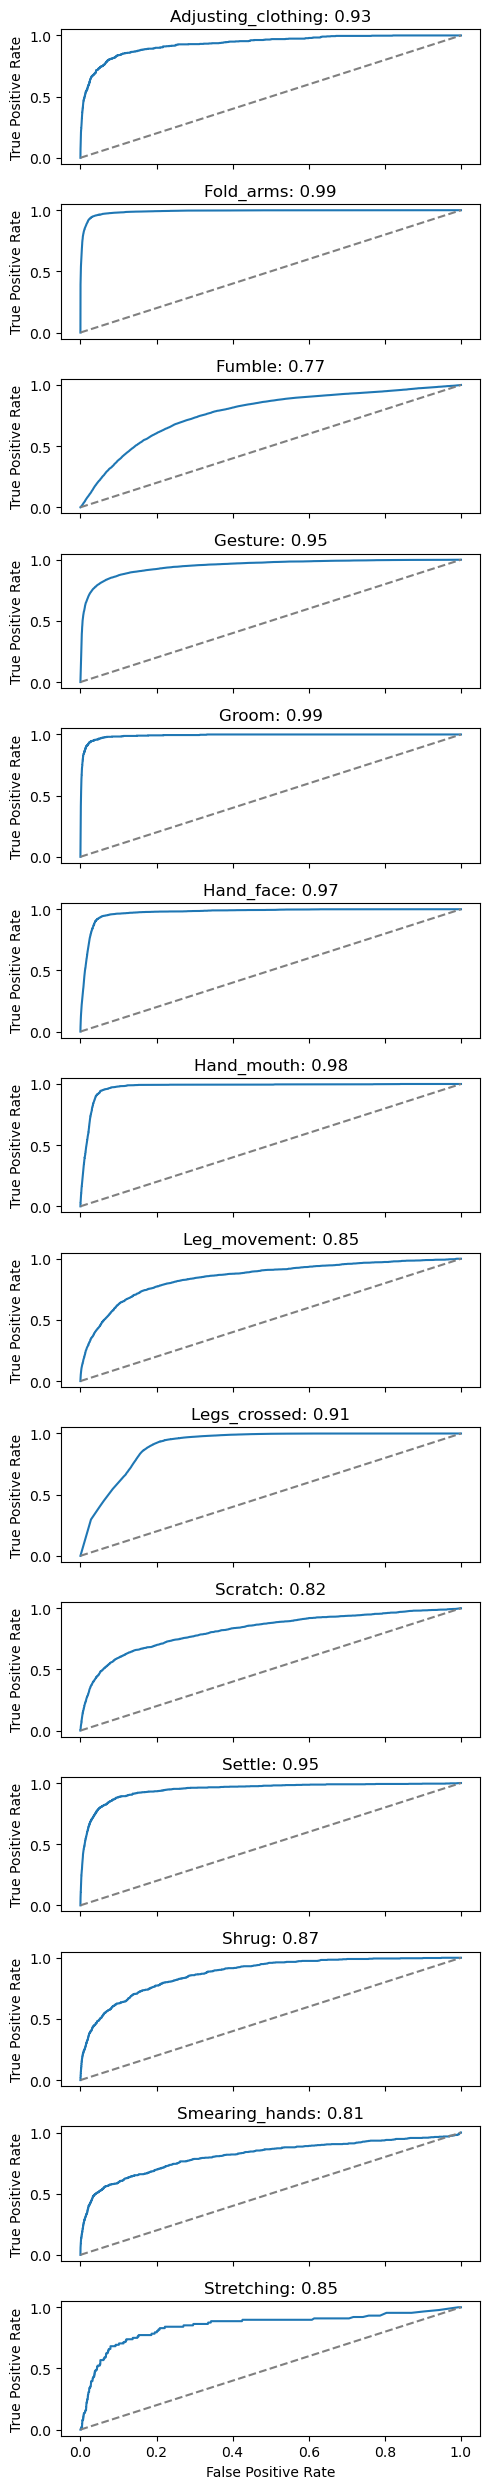

In [30]:
# Plot ROC curves and display additional information
# fig, axes = plt.subplots(nrows=1, ncols=len(roc_metrics), figsize=(15, 5))
num_lables = len(roc_metrics)
fig, axes = plt.subplots(nrows=num_lables, ncols=1, figsize=(5, 25))

for i, (label, metrics) in enumerate(roc_metrics.items()):
    tpr = metrics['tpr']
    fpr = metrics['fpr']
    auc = metrics['auc']
    auc_value = metrics['auc']

    # Plot ROC curve
    axes[i].plot(fpr, tpr, label=f'AUC = {auc_value:.2f}')
    axes[i].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')

    # Add title, AUC value, and additional information

    # axes[i].set_title(label)
    axes[i].set_title(f'{label}: {auc_value:.2f}')
    # axes[i].set_xlabel('False Positive Rate')
    axes[i].set_ylabel('True Positive Rate')
    # if i==0:
    if i == num_lables-1:
        # axes[i].set_ylabel('True Positive Rate')
        axes[i].set_xlabel('False Positive Rate')
    # axes[i].legend(loc='lower right')
    else:
        # axes[i].set_yticklabels([])
        axes[i].set_xticklabels([])

    # Add text with additional information
    # axes[i].text(0.5, 0.1, f'True: {true_counts[label]}\nCorrect: {correct_counts[label]}\nMisclassified: {misclassified_counts[label]}',
    #              ha='center', va='center', bbox=dict(facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()

    

In [31]:
# print("Mean Average Precision:", map_score)

In [33]:
df.reset_index()[['sample_id', 'rec_no', 'subject_pos', 'view']].head()

,sample_id,rec_no,subject_pos,view
0,1644,8,1,front1
1,1644,8,1,front2
2,1644,8,1,left
3,1644,8,1,right
4,1645,8,1,front1


In [34]:
df.columns

Index(['index', 'sample_id', 'rec_no', 'subject_pos', 'view',
       'logit-Adjusting_clothing', 'logit-Fold_arms', 'logit-Fumble',
       'logit-Gesture', 'logit-Groom', 'logit-Hand_face', 'logit-Hand_mouth',
       'logit-Leg_movement', 'logit-Legs_crossed', 'logit-Scratch',
       'logit-Settle', 'logit-Shrug', 'logit-Smearing_hands',
       'logit-Stretching', 'pred-Adjusting_clothing', 'pred-Fold_arms',
       'pred-Fumble', 'pred-Gesture', 'pred-Groom', 'pred-Hand_face',
       'pred-Hand_mouth', 'pred-Leg_movement', 'pred-Legs_crossed',
       'pred-Scratch', 'pred-Settle', 'pred-Shrug', 'pred-Smearing_hands',
       'pred-Stretching', 'gt-Adjusting_clothing', 'gt-Fold_arms', 'gt-Fumble',
       'gt-Gesture', 'gt-Groom', 'gt-Hand_face', 'gt-Hand_mouth',
       'gt-Leg_movement', 'gt-Legs_crossed', 'gt-Scratch', 'gt-Settle',
       'gt-Shrug', 'gt-Smearing_hands', 'gt-Stretching'],
      dtype='object')

In [35]:
df_view_agg = df.drop(columns='view').groupby('sample_id').mean()
y_true = df_view_agg[gt_columns].astype(int).values
y_pred = df_view_agg[logit_columns].values
print(average_precision_score(y_true=y_true, y_score=y_pred, average='micro'))
print(average_precision_score(y_true=y_true, y_score=y_pred, average='macro'))

0.7651718341414588
0.5131083579474737


In [36]:
df_view_agg = df.drop(columns='view').groupby('sample_id').mean()
y_true = df_view_agg[gt_columns].astype(int).values
y_pred = df_view_agg[logit_columns].values
print(average_precision_score(y_true=y_true, y_score=y_pred, average='micro'))
print(average_precision_score(y_true=y_true, y_score=y_pred, average='macro'))

0.7629838041410952
0.4996586589936696


In [37]:
df_view_agg = df.loc[df['view']=='front1'].drop(columns='view').groupby('sample_id').mean()
y_true = df_view_agg[gt_columns].astype(int).values
y_pred = df_view_agg[logit_columns].values
print(average_precision_score(y_true=y_true, y_score=y_pred, average='micro'))
print(average_precision_score(y_true=y_true, y_score=y_pred, average='macro'))

0.7671948163119165
0.49639497987933456


In [38]:
df_view_agg = df.loc[df['view']=='front2'].drop(columns='view').groupby('sample_id').mean()
y_true = df_view_agg[gt_columns].astype(int).values
y_pred = df_view_agg[logit_columns].values
print(average_precision_score(y_true=y_true, y_score=y_pred, average='micro'))
print(average_precision_score(y_true=y_true, y_score=y_pred, average='macro'))

0.7420309618601534
0.4862354750444709


In [39]:
df_view_agg = df.loc[df['view']=='left'].drop(columns='view').groupby('sample_id').mean()
y_true = df_view_agg[gt_columns].astype(int).values
y_pred = df_view_agg[logit_columns].values
print(average_precision_score(y_true=y_true, y_score=y_pred, average='micro'))
print(average_precision_score(y_true=y_true, y_score=y_pred, average='macro'))b

0.6763615788751387
0.4662588806922973


In [41]:
df_view_agg = df.loc[df['view']=='right'].drop(columns='view').groupby('sample_id').mean()
y_true = df_view_agg[gt_columns].astype(int).values
y_pred = df_view_agg[logit_columns].values
print(average_precision_score(y_true=y_true, y_score=y_pred, average='micro'))
print(average_precision_score(y_true=y_true, y_score=y_pred, average='macro'))

0.7180842528199595
0.4798331303053721


In [42]:
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix

# Assuming y_true and y_pred are your true and predicted labels for a multilabel classification task
# Each sample can have multiple labels

# Compute multilabel confusion matrix
mcm = multilabel_confusion_matrix(y_true, y_pred>0.5)

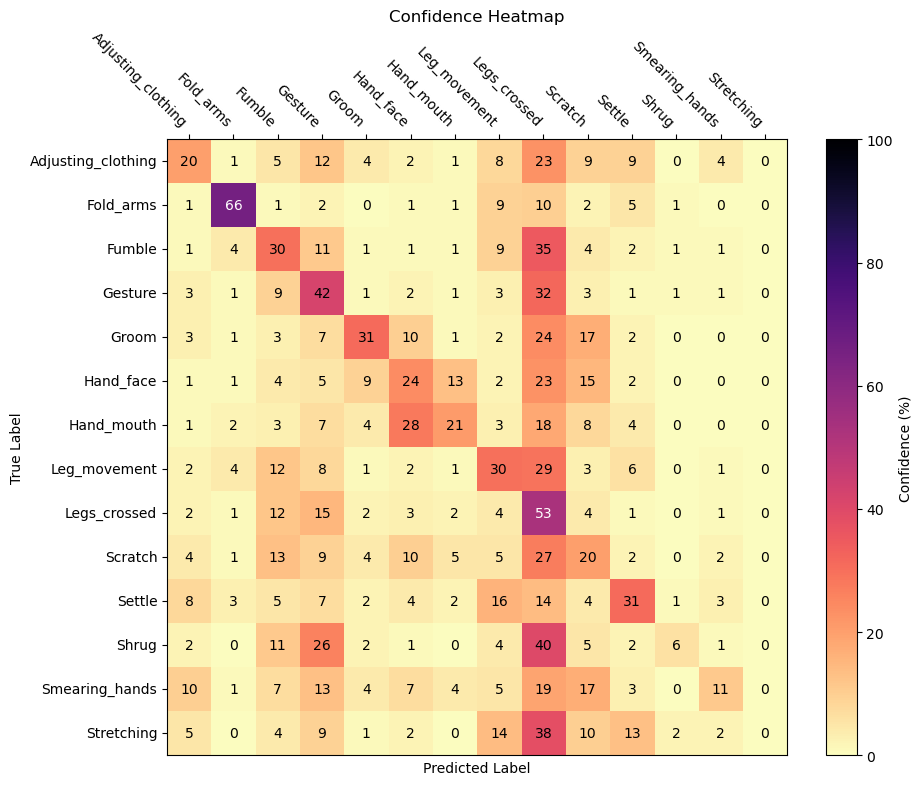

In [43]:
import matplotlib.pyplot as plt


def plot_confidence_heatmap(y_true, y_pred, feature_names):
    n_features = len(feature_names)
    n_samples = y_true.shape[0]

    # Initialize a matrix to store confidence values for each label
    confidence_matrix = np.zeros((n_features, n_features))

    # Iterate through each label
    for label_idx in range(n_features):
        # Get indices where ground truth is 1 for the current label
        label_indices = np.where(y_true[:, label_idx] == 1)[0]

        # If no samples have this label, skip
        if len(label_indices) == 0:
            continue

        # Get mean y_pred vector for rows where ground truth is 1 for this label
        mean_y_pred = np.mean(y_pred[label_indices], axis=0)  
        mean_y_pred /= np.sum(mean_y_pred)
        mean_y_pred *= 100  # Convert to percentage confidence value
        mean_y_pred = np.round(mean_y_pred).astype(int)  # Round 

        # Store the confidence values for the current label
        confidence_matrix[label_idx] = mean_y_pred # Convert to int

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    plt.imshow(confidence_matrix, cmap='magma_r', aspect='auto', vmin=0, vmax=100)  # Set colormap scale
    plt.colorbar(label='Confidence (%)')
    for i in range(n_features):
        for j in range(n_features):
            c = 'white' if confidence_matrix[i, j] > 50 else 'black'  # Set text color based on confidence value
            plt.text(j, i, str(int(confidence_matrix[i, j])), ha='center', va='center', color=c)
    plt.xticks(np.arange(n_features), feature_names, rotation=-45, ha='right')
    plt.yticks(np.arange(n_features), feature_names, rotation=0, va='center')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confidence Heatmap')
    plt.grid(False)  # Remove grid
    plt.tick_params(axis='both', direction='out')  # Ticks pointing outside
    plt.tick_params(axis='y', right=False, left=True)  # Move y-axis ticks to the left
    plt.gca().xaxis.set_ticks_position('top')  # Move x-axis ticks to the top

    # plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)  # Adjust subplot to fit labels
    plt.show()

plot_confidence_heatmap(y_true, y_pred, feature_names)